    # RS Virus RNA-Seq 
    ================
    Author: Aviv Leemann 
    Date: 2023-19-11
    Description: RSV or RS virus, short for respiratory syncytial virus, is a single-stranded RNA virus belonging to the pneumovirus genus of the virus family.
                Symptoms are usually mild, similar to a cold, but can cause very serious illness in infants.
                a total of 8 RNA-Seq data from acute and chronic phases in nasal samples of 4 infants.


## Import

In [319]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from pathlib import Path
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pickle as pkl
import matplotlib.pyplot as plt

## variables

variable | description
---|---
@data_path | Path to the data csv file.
@out_path | Path to the output folder.
@data | Dataframe containing the data.
@n_cpus_use | Number of cpus to use.
@padj_cutoff | Adjusted p-values cutoff.
@lfc2_cutoff | Log2 fold change cutoff.



In [218]:
count_file_path = list(Path().cwd().glob('*count*.csv'))[0]

In [192]:
data_path = Path().cwd() / 'RSV_count.csv'
output = Path().cwd()
n_cpus_use = 2
padj_cutoff = 0.05
lfc2_cutoff = 2

## assign significance function

In [191]:
def assign_sig(p_value : int, log2FoldChange: int, padj: float=padj_cutoff , lfc2: int=lfc2_cutoff ) -> str:
   '''
   assigns a gene to a category based on the p_value and log2FoldChange, p_value and lfc2, p_value, lfc2 or non-sig.
   p_value and lfc2: abs(log2FoldChange) > 2 and p_value < 0.05.
   p_value: abs(log2FoldChange) <= 2 and p_value < 0.05.
   lfc2: abs(log2FoldChange) > 2 and p_value >= 0.05.
   @param p_value: p_value.
   @param log2FoldChange: log2foldchange.
   @param padj: p_value cutoff.
   @param lfc2: log2foldchange cutoff.
   '''
   if p_value < padj and abs(log2FoldChange) > lfc2 :
      return 'lfc2 and p_value'
   elif p_value < padj and   abs(log2FoldChange)  <= lfc2: 
      return 'p_value'
   elif p_value >= padj and  abs(log2FoldChange)  > lfc2:
      return 'lfc2'
   else:
      return 'non-sig'

In [189]:
data = pd.read_csv(data_path, index_col=0)
data.shape

(28278, 13)

In [100]:
data.head()

Chr  \
Geneid                                                         
DDX11L1                                       chr1;chr1;chr1   
WASH7P     chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...   
MIR6859-1                              chr1;chr1;chr16;chr15   
MIR6859-2                              chr1;chr1;chr16;chr15   
MIR6859-3                              chr1;chr1;chr16;chr15   

                                                       Start  \
Geneid                                                         
DDX11L1                                    11874;12613;13221   
WASH7P     14362;14970;15796;16607;16858;17233;17606;1791...   
MIR6859-1                       17369;187891;17052;101973524   
MIR6859-2                       17369;187891;17052;101973524   
MIR6859-3                       17369;187891;17052;101973524   

                                                         End  \
Geneid                                                         
DDX11L1                                    12227;12721;14409   
WASH7P     14829;15038;15947;16765;17055;17368;17742;1806...   
MIR6859-1                       17436;187958;17119;101973591   
MIR6859-2                       17436;187958;17119;101973591   
MIR6859-3                       17436;187958;17119;101973591   

                          Strand  Length  SRR7011737  SRR7011738  SRR7011742  \
Geneid                                                                         
DDX11L1                    +;+;+    1652           0           0           0   
WASH7P     -;-;-;-;-;-;-;-;-;-;-    1769           2           8           0   
MIR6859-1                -;-;-;+     272           0           0           0   
MIR6859-2                -;-;-;+     272           0           0           0   
MIR6859-3                -;-;-;+     272           0           0           0   

           SRR7011743  SRR7011755  SRR7011756  SRR7011757  SRR7011758  
Geneid                                                                 
DDX11L1             0           0           0           0           0  
WASH7P             17           2           1           2           5  
MIR6859-1           0           0           0           0           0  
MIR6859-2           0           0           0           0           0  
MIR6859-3           0           0           0           0           0

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28278 entries, DDX11L1 to TMEM181
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Chr         28278 non-null  object
 1   Start       28278 non-null  object
 2   End         28278 non-null  object
 3   Strand      28278 non-null  object
 4   Length      28278 non-null  int64 
 5   SRR7011737  28278 non-null  int64 
 6   SRR7011738  28278 non-null  int64 
 7   SRR7011742  28278 non-null  int64 
 8   SRR7011743  28278 non-null  int64 
 9   SRR7011755  28278 non-null  int64 
 10  SRR7011756  28278 non-null  int64 
 11  SRR7011757  28278 non-null  int64 
 12  SRR7011758  28278 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 3.0+ MB


In [139]:
df_counts = data[data.columns[data.columns.str.contains('SRR.*')]].T
# Convert the count matrix to numeric values and replace NaN with zeros
df_counts = df_counts.apply(pd.to_numeric, errors='coerce').fillna(0)
df_counts = df_counts[df_counts.columns[df_counts.sum(axis=0) >= 10]]
df_counts = df_counts.rename_axis(None, axis=0).rename_axis(None, axis=1)
df_counts

WASH7P  LOC729737  TGIF1  PRDX6   CIC  LOC100133331  FAM87B  \
SRR7011737       2        126   1547   6278  1620            24       2   
SRR7011738       8        177   1337   5318  1547            36       1   
SRR7011742       0         14   1297   4455  1220            16       1   
SRR7011743      17         34   1227   5442  1421            42       4   
SRR7011755       2         75   1645   4468  1856            29       5   
SRR7011756       1        142   1297   4418  1646            34       3   
SRR7011757       2         77   1561   4776  1815            26       4   
SRR7011758       5        309   1389   3599  1640            16       4   

            LINC00115  LINC01128  FAM41C  ...  EXOC1L  TTC31  PDE8B  CHD1  \
SRR7011737          9        212       1  ...       7    713    882  1368   
SRR7011738          6        227       1  ...      33    547    401  1230   
SRR7011742          9        122       0  ...       0    668   1289  1049   
SRR7011743         11        175       3  ...      17    409    199  1518   
SRR7011755          3        135       4  ...       5    676    713  1696   
SRR7011756          6        144       1  ...       7    541    101  1369   
SRR7011757          7        180       1  ...      22    699    500  1382   
SRR7011758         10        104       0  ...       2    468     22  1601   

             GLA  PAK1  PRKD3  MLC1  ZBTB41  TMEM181  
SRR7011737   317  2791    500    10     387     1870  
SRR7011738   370  2520    508    23     326     1418  
SRR7011742   439  3038    576     4     549     1619  
SRR7011743   411  2582    864     5     555     1201  
SRR7011755   463  3558    956    14     877     1748  
SRR7011756   842  2156    921     4     517     1466  
SRR7011757   557  2908    824    24     728     1894  
SRR7011758  1069  2013    686     4     229     1009  

[8 rows x 19207 columns]

In [140]:
metadata_d = {'patient1' : {'acute' : 'SRR7011737', 'chronic' : 'SRR7011738', 'Age' : '0.31-0.54yr'},
            'patient2' : {'acute' : 'SRR7011742', 'chronic' : 'SRR7011743', 'Age' : '0.24-0.35yr'},
            'patient3' : {'acute' : 'SRR7011755', 'chronic' : 'SRR7011756', 'Age' :  '0.23-0.36yr'},
            'patient4' : {'acute' : 'SRR7011757', 'chronic' : 'SRR7011758', 'Age' : '0.84-0.96yr'}}
metadata = (pd.DataFrame().from_dict(metadata_d, orient='index').reset_index().rename(columns={'index' : 'patient'})
            .melt(id_vars=['patient'], value_vars=['acute', 'chronic'], var_name='condition', value_name='sample')
            .drop('patient', axis=1)[['sample', 'condition']])
metadata.set_index('sample', inplace=True)
metadata.rename_axis(None, inplace=True)

## Deffrential expression analysis
Run DEseq2.</br>
pydeseq2 is Used to perform differential expression analysis.

Check if all samples in metadata are in df_counts:
```python
df_counts.index.isin(metadata.index).all()
```
Check if all samples in df_counts are in metadata:
```python
metadata.index.isin(df_counts.index).all()

```

In [190]:

print(df_counts.index.isin(metadata.index).all(),metadata.index.isin(df_counts.index).all(), sep='\n')   

True
True


1. Convert index to string type and ensure indices match:
```python 
    df_counts.index = df_counts.index.astype(str)
```
2. Convert sample column to string type# Ensure indices match:
```python   
    metadata.index = metadata.index.astype(str)
```
3. Reorder df_counts and metadata to have the same index order:
```python
    df_counts = df_counts.reindex(metadata.index)
```

In [194]:

df_counts.index = df_counts.index.astype(str)  
metadata.index = metadata.index.astype(str)  
df_counts = df_counts.reindex(metadata.index)

In [144]:
dds = DeseqDataSet(
    counts=df_counts,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    n_cpus=n_cpus_use,
)
dds.deseq2( )

save DEseq2 Object to pickle file:

In [196]:
with open( output / "dds.pkl", "wb") as f:
    pkl.dump(dds, f)

## Statistical analysis
Run statistical analysis.</br>

In [150]:
stat_res = DeseqStats(dds, n_cpus = n_cpus_use)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition chronic vs acute


... done in 4.50 seconds.



baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
WASH7P        4.587857        2.458706  1.116766  2.201630  0.027691  0.202064
LOC729737   122.155762        1.342039  0.716822  1.872207  0.061178  0.309724
TGIF1      1400.037490       -0.099168  0.142399 -0.696411  0.486171  0.796121
PRDX6      4794.111981       -0.008120  0.200802 -0.040440  0.967742  0.991057
CIC        1581.916300        0.053769  0.177791  0.302430  0.762324  0.925608
...                ...             ...       ...       ...       ...       ...
PAK1       2658.104961       -0.314881  0.129934 -2.423387  0.015377  0.143495
PRKD3       722.336078        0.175513  0.290260  0.604675  0.545395  0.827693
MLC1         10.608723       -0.444787  0.810487 -0.548790  0.583150  0.846594
ZBTB41      508.407691       -0.547094  0.350267 -1.561933  0.118304  0.427640
TMEM181    1506.912048       -0.395167  0.160578 -2.460906  0.013859  0.135332

[19207 rows x 6 columns]

In [156]:
res = stat_res.results_df.reset_index().rename(columns={'index':'gene_id','log2FoldChange':'log2FC','pvalue':'p_value','padj':'p_adj'})
res.to_csv(output / 'deseq2_results.csv', index=False)

In [162]:
sigs = res[(abs(res.log2FC) > 2) & (res.p_adj < 0.05) ]
sigs.to_csv(output / 'deseq2_results_sigs.csv', index=False)

## processings and plots

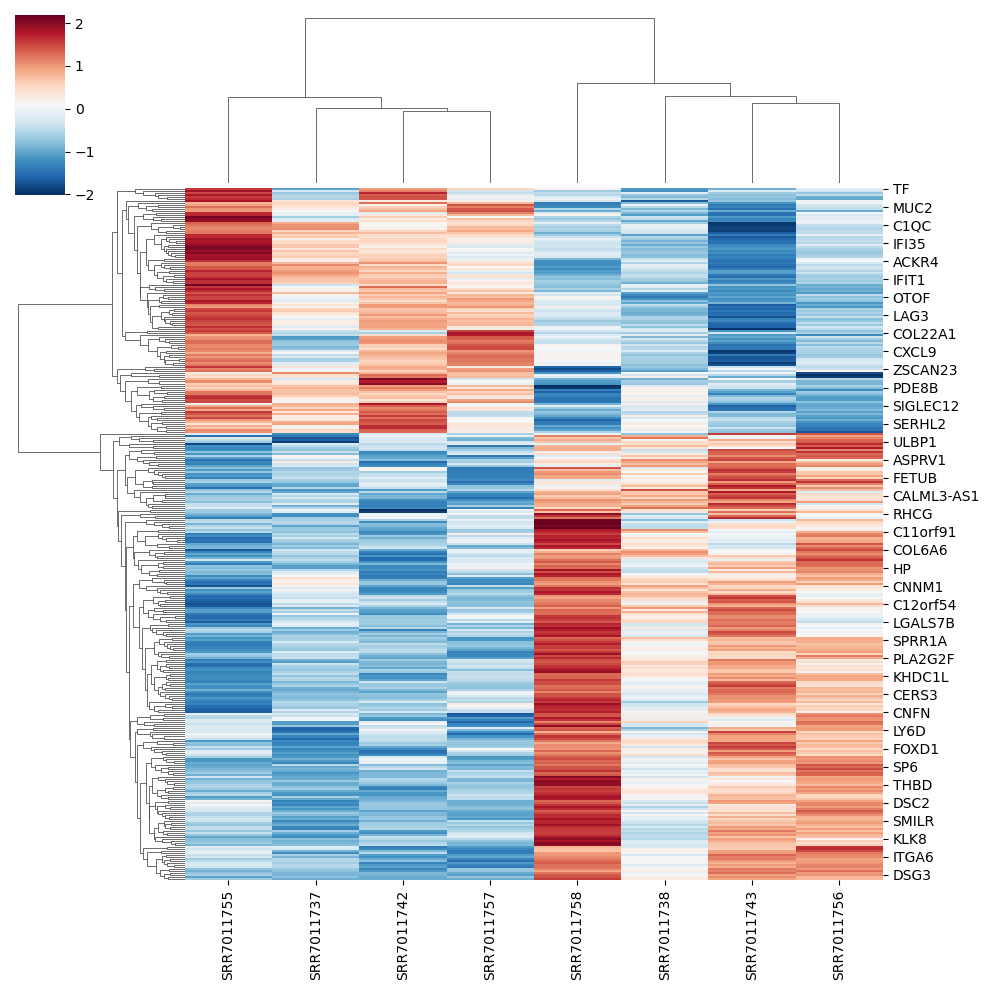

In [164]:

dds.layers['log1p'] = np.log1p(dds.layers['normed_counts']) # log1p transform the normalized counts
dds_sigs = dds[:, sigs.index]

grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,index=dds_sigs.var_names, columns=dds_sigs.obs_names)
pheat = sns.clustermap(grapher, z_score=0, cmap = 'RdBu_r')
pheat
pheat.savefig(output/ "significant_genes_heatmap_seaborn.png", dpi=300)

## Volcano plot - interactive
plotly used to create volcano plot.</br>
The plot is interactive and can be used to zoom in and out and to hover over points to see the gene name and the log2 fold change and the p-value.

In [197]:
res = res.assign(log10pvalue = -np.log10(res.p_value),
                sig = (res.p_value < 0.05) & (abs(res.log2FC) > 2),
                regulated = res[['p_value','log2FC']].apply( lambda x: assign_sig(x.p_value, x.log2FC ), axis=1))
res.head()

gene_id     baseMean    log2FC     lfcSE      stat   p_value     p_adj  \
0     WASH7P     4.587857  2.458706  1.116766  2.201630  0.027691  0.202064   
1  LOC729737   122.155762  1.342039  0.716822  1.872207  0.061178  0.309724   
2      TGIF1  1400.037490 -0.099168  0.142399 -0.696411  0.486171  0.796121   
3      PRDX6  4794.111981 -0.008120  0.200802 -0.040440  0.967742  0.991057   
4        CIC  1581.916300  0.053769  0.177791  0.302430  0.762324  0.925608   

   log10pvalue    sig         regulated  
0     1.557654   True  lfc2 and p_value  
1     1.213405  False           non-sig  
2     0.313211  False           non-sig  
3     0.014240  False           non-sig  
4     0.117860  False           non-sig

In [211]:
import plotly.express as px
plot_title = "Volcano plot control vs treatment" #@param {type:"string"}
x_axis_title = "log2 fold change" #@param {type:"string"}
y_axis_title = "-log10(pvalue)" #@param {type:"string"}
point_radius = 7 #@param {type:"slider", min:1, max:30, step:1}
choices = {'lfc2 and p_value': 'red', 'p_value': 'blue', 'non-sig': 'grey','lfc2':'green'}
colors = res.regulated.transform(lambda x: choices.get(x))

fig = px.scatter(data_frame=res,
    x='log2FC',
    y='log10pvalue',
    title=plot_title,
    hover_data=['gene_id', 'regulated'],
    labels={
        "x": x_axis_title,
        "y": y_axis_title
    },
    width=900,
    height=700
)
fig.update_layout({
'paper_bgcolor': 'white',
})
fig.update_traces(marker=dict(size=point_radius, color=colors))
fig.add_hline(y=-np.log10(0.05), line_dash="dash", line_color="grey")
fig.add_vline(x=2, line_dash="dash", line_color="grey")
fig.add_vline(x=-2, line_dash="dash", line_color="grey")
# Export the figure to HTML
fig.write_html(output / "volcano_plot_plotly.html")
fig.show()

# Volcano plot - static
matplotlib package was used to plot the volcano plot as a static plot.

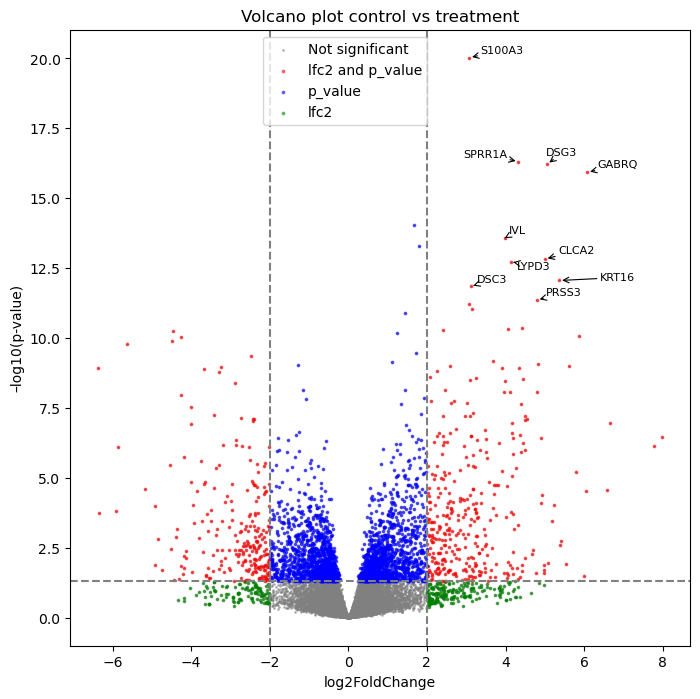

In [235]:
from adjustText import adjust_text

plt.figure(figsize=(8,8))
plt.scatter(x=res.log2FC, y=res.log10pvalue, s=1, label="Not significant", color="grey", alpha=0.5)

# highlight pvalue, lfc2 and both, separately according the significant genes value decided by the user
lfc2_df = res[res.regulated == 'lfc2']
pvalue_df = res[res.regulated == 'p_value']
both_df = res[res.regulated == 'lfc2 and p_value']

plt.scatter(x=both_df.log2FC, y=both_df.log10pvalue, s=3, label='lfc2 and p_value', color="red", marker="o", alpha=0.5)
plt.scatter(x=pvalue_df.log2FC, y=pvalue_df.log10pvalue, s=3, label="p_value", color="blue", marker="o", alpha=0.5)
plt.scatter(x=lfc2_df.log2FC, y=lfc2_df.log10pvalue, s=3, label="lfc2", color="green", marker="o", alpha=0.5)

both_df.index = both_df.gene_id

# Add labels to the 10 highest values on the y-axis
texts = []
top_10_indices = both_df.log10pvalue.nlargest(10).index
for i, index in enumerate(top_10_indices):
    texts.append(plt.text(both_df.loc[index, 'log2FC'], both_df.loc[index, 'log10pvalue'], index, fontsize=8))

# Adjust the position of the labels to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.8), expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))   

plt.xlabel("log2FoldChange")
plt.ylabel("–log10(p-value)")
plt.title("Volcano plot control vs treatment")
plt.axvline(-2, color="grey", linestyle="--")
plt.axvline(2, color="grey", linestyle="--")
plt.axhline(-np.log10(0.05), color="grey", linestyle="--")
plt.legend(loc='upper left', bbox_to_anchor=(0.3, 1))

# save the plot
plt.savefig(output / "volcano_plot_matplotlib.png", dpi=300)

In [280]:
res.head()

gene_id     baseMean    log2FC     lfcSE      stat   p_value     p_adj  \
0     WASH7P     4.587857  2.458706  1.116766  2.201630  0.027691  0.202064   
1  LOC729737   122.155762  1.342039  0.716822  1.872207  0.061178  0.309724   
2      TGIF1  1400.037490 -0.099168  0.142399 -0.696411  0.486171  0.796121   
3      PRDX6  4794.111981 -0.008120  0.200802 -0.040440  0.967742  0.991057   
4        CIC  1581.916300  0.053769  0.177791  0.302430  0.762324  0.925608   

   log10pvalue    sig         regulated  
0     1.557654   True  lfc2 and p_value  
1     1.213405  False           non-sig  
2     0.313211  False           non-sig  
3     0.014240  False           non-sig  
4     0.117860  False           non-sig

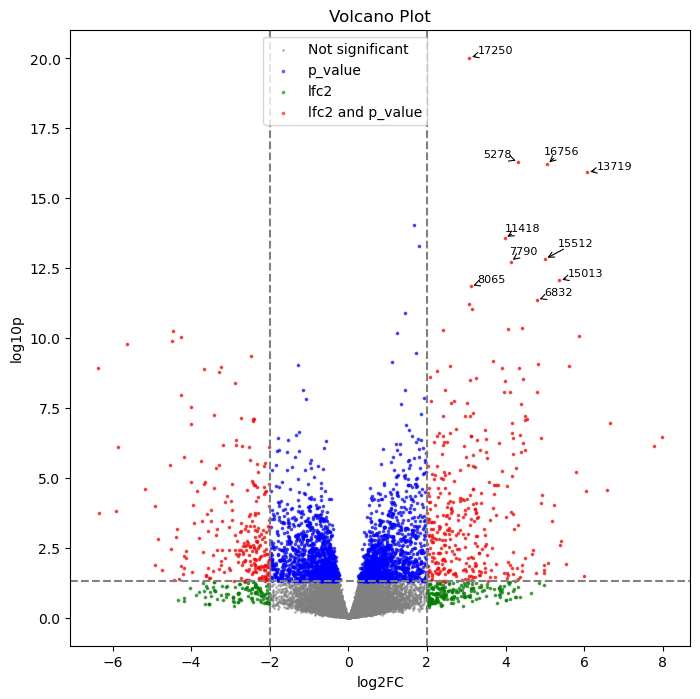

In [322]:

import matplotlib.pyplot as plt
from typing import Optional, Type
import pandas as pd
import numpy as np

def VolcanoPlot(df: Type[pd.DataFrame], x: str = 'log2FC', y: str = 'log10p', 
                xline_color: str = 'grey', yline_color: str = 'grey', line_style: str = '--',
                loc: str = 'upper left', bbox_to_anchor: Optional[tuple] = (0.3, 1),
                figsize: tuple = (8, 8), axline: float = 2, title: str = "Volcano Plot",
                top_n: int = 10, save_path: Optional[str] = None,dpi: int=300 , **kwargs) -> None:
    """
    Generate a volcano plot to visualize differential gene expression.

    Parameters:
    - df: pandas DataFrame containing the data.
    - x: column name for the x-axis.
    - y: column name for the y-axis.
    - xline_color: color of the vertical lines.
    - yline_color: color of the horizontal line.
    - line_style: style of the lines.
    - loc: location of the legend (e.g., 'upper left', 'lower right', 'center', etc.).
    - bbox_to_anchor: anchor point of the legend.
    - figsize: size of the figure.
    - axline: x-axis value for the vertical lines.
    - title: title of the plot.
    - top_n: number of top genes to label.
    - save_path: path to save the plot as an image file (optional).
    - **kwargs: additional keyword arguments for scatter plot customization.

    Returns:
    - None
    """
    if 'regulated' not in df.columns:
        df['regulated'] = df.apply(lambda row: assign_sig(row['p_value'], row['log2FC']), axis=1)

    plt.figure(figsize=figsize)
    plt.scatter(x=df[x], y=df[y], s=1, label="Not significant", color="grey", alpha=0.5, **kwargs)

    lfc2_df = df[df.regulated == 'lfc2'].copy()
    pvalue_df = df[df.regulated == 'p_value'].copy()
    both_df = df[df.regulated == 'lfc2 and p_value'].copy()

    plt.scatter(x=pvalue_df[x], y=pvalue_df[y], s=3, label="p_value", color="blue", marker="o", alpha=0.5, **kwargs)
    plt.scatter(x=lfc2_df[x], y=lfc2_df[y], s=3, label="lfc2", color="green", marker="o", alpha=0.5, **kwargs)
    plt.scatter(x=both_df[x], y=both_df[y], s=3, label='lfc2 and p_value', color="red", marker="o", alpha=0.5, **kwargs)

    texts = []
    top_n_indices = both_df[y].nlargest(top_n).index
    for i, index in enumerate(top_n_indices):
        texts.append(plt.text(both_df.loc[index, x], both_df.loc[index, y], index, fontsize=8))

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.8), expand_points=(1.5, 1.5), expand_text=(1.5, 1.5))

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.axvline(-axline, color=xline_color, linestyle=line_style)
    plt.axvline(axline, color=xline_color, linestyle=line_style)
    plt.axhline(-np.log10(0.05), color=yline_color, linestyle=line_style)
    plt.legend(loc=loc, bbox_to_anchor=bbox_to_anchor)

    if save_path:
        plt.savefig(save_path, dpi=dpi)

    plt.show()


def assign_sig(p_value : int, log2FoldChange: int, padj: float=padj_cutoff , lfc2: int=lfc2_cutoff ) -> str:
   '''
   assigns a gene to a category based on the p_value and log2FoldChange, p_value and lfc2, p_value, lfc2 or non-sig.
   p_value and lfc2: abs(log2FoldChange) > 2 and p_value < 0.05.
   p_value: abs(log2FoldChange) <= 2 and p_value < 0.05.
   lfc2: abs(log2FoldChange) > 2 and p_value >= 0.05.
   parameters:
   - p_value: p_value.
   - log2FoldChange: log2foldchange.
   - padj: p_value cutoff.
   - lfc2: log2foldchange cutoff.
   
   returns:
   label: str 
   '''
   if p_value < padj and abs(log2FoldChange) > lfc2 :
      return 'lfc2 and p_value'
   elif p_value < padj and   abs(log2FoldChange)  <= lfc2: 
      return 'p_value'
   elif p_value >= padj and  abs(log2FoldChange)  > lfc2:
      return 'lfc2'
   else:
      return 'non-sig'
  
VolcanoPlot(df=res,x='log2FC', y ='log10p')

# conclusion:
The volcano plot shows the genes that are significantly differentially expressed between the acute and chronic phases in nasal samples of 4 infants.</br>
The genes that are significantly differentially expressed are the genes that are located in the upper part of the plot and are colored in red.


In [219]:
sigs

gene_id     baseMean    log2FC     lfcSE      stat       p_value  \
16        C1QB  1490.915608 -2.144842  0.521587 -4.112147  3.919967e-05   
108       CPA4  9383.151434  2.585207  0.422850  6.113775  9.730154e-10   
288       AFF2    30.042817  4.198375  0.870055  4.825416  1.397113e-06   
300      PTPRR    31.113536 -2.886250  0.882736 -3.269664  1.076753e-03   
315      KLRD1    96.155025 -2.426465  0.801072 -3.029023  2.453458e-03   
...        ...          ...       ...       ...       ...           ...   
19153     LGI3    17.919873  2.829812  0.709538  3.988243  6.656443e-05   
19164   CYP2C9     4.457370  3.515249  1.158382  3.034619  2.408396e-03   
19165  CYP2C19     7.471777  3.235053  1.057387  3.059478  2.217231e-03   
19190    SUGCT    19.420392  2.179437  0.612010  3.561111  3.692890e-04   
19199    PDE8B   502.869630 -2.212520  0.674247 -3.281468  1.032684e-03   

              p_adj  
16     2.425162e-03  
108    5.398352e-07  
288    1.753938e-04  
300    2.593708e-02  
315    4.571726e-02  
...             ...  
19153  3.588845e-03  
19164  4.507290e-02  
19165  4.241842e-02  
19190  1.221423e-02  
19199  2.524292e-02  

[345 rows x 7 columns]

In [321]:
from VolcanoPlot import VolcanoPlot

gene_id     baseMean    log2FC     lfcSE      stat   p_value  \
0         WASH7P     4.587857  2.458706  1.116766  2.201630  0.027691   
1      LOC729737   122.155762  1.342039  0.716822  1.872207  0.061178   
2          TGIF1  1400.037490 -0.099168  0.142399 -0.696411  0.486171   
3          PRDX6  4794.111981 -0.008120  0.200802 -0.040440  0.967742   
4            CIC  1581.916300  0.053769  0.177791  0.302430  0.762324   
...          ...          ...       ...       ...       ...       ...   
19202       PAK1  2658.104961 -0.314881  0.129934 -2.423387  0.015377   
19203      PRKD3   722.336078  0.175513  0.290260  0.604675  0.545395   
19204       MLC1    10.608723 -0.444787  0.810487 -0.548790  0.583150   
19205     ZBTB41   508.407691 -0.547094  0.350267 -1.561933  0.118304   
19206    TMEM181  1506.912048 -0.395167  0.160578 -2.460906  0.013859   

          p_adj    log10p    sig         regulated  
0      0.202064  1.557654   True  lfc2 and p_value  
1      0.309724  1.213405  False           non-sig  
2      0.796121  0.313211  False           non-sig  
3      0.991057  0.014240  False           non-sig  
4      0.925608  0.117860  False           non-sig  
...         ...       ...    ...               ...  
19202  0.143495  1.813142  False           p_value  
19203  0.827693  0.263289  False           non-sig  
19204  0.846594  0.234220  False           non-sig  
19205  0.427640  0.927002  False           non-sig  
19206  0.135332  1.858278  False           p_value  

[19207 rows x 10 columns]

# References:
1. pydeseq2: 